The baseline configuration for three models was no data augmentation, a learning_rate of 0.001, and a batch_size of 64. Modifications were applied individually to evaluate their impact: applying data augmentation, increasing the learning rate to 0.01, and reducing the batch size to 32.

##### 1. Training time of different algorithms under different settings

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_runtime(directory, setting):
    ''' Plot runtimes from .csv files in a directory '''
    
    runtimes = {}

    for file in os.listdir(directory):
        if 'runtime' in file:
            filepath = os.path.join(directory, file)
            df = pd.read_csv(filepath)
            model_name = file.replace('runtime_', '').replace('.csv', '')
            runtimes[model_name] = df.values
    
    plt.figure(figsize=(5, 3))
    for model, runtime_values in runtimes.items():
        plt.plot(runtime_values, label=model)
    plt.title(f'Model Runtime Comparison - {setting}')
    plt.xlabel('Epoch')
    plt.ylabel('Runtime (secs)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

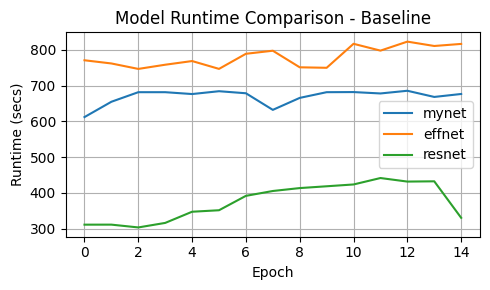

In [58]:
plot_runtime('result', 'Baseline')

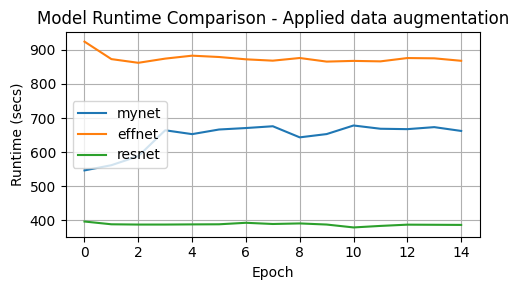

In [59]:
plot_runtime('result_augment', 'Applied data augmentation')

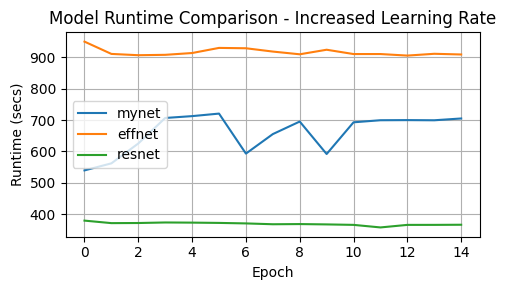

In [60]:
plot_runtime('result_lr', 'Increased Learning Rate')

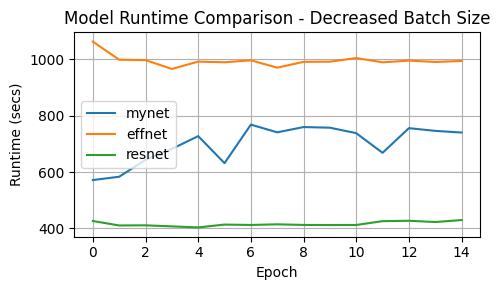

In [61]:
plot_runtime('result_batchsize', 'Decreased Batch Size')

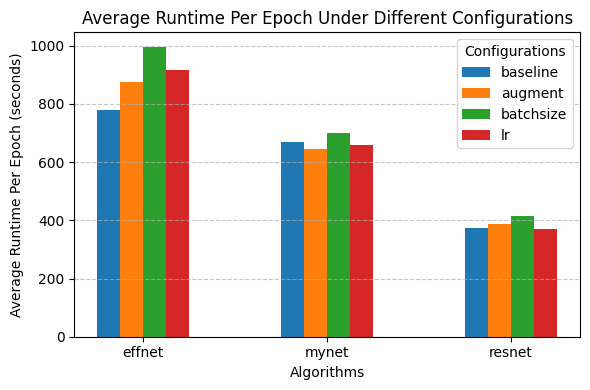

In [8]:
def plot_runtime_histogram(folders):
    '''
    Plot a histogram of average runtimes from CSV files across multiple folders.
    '''
    # a dictictionary of dictionaries, 
    # where keys are folder names representing different configurations
    # and values are dictionaries containing pairs of model_name: avg_runtime
    runtimes = {}  

    for folder in folders:
        runtimes[folder] = {}

        for file in os.listdir(folder):
            if "runtime" in file:
                filepath = os.path.join(folder, file)
                df = pd.read_csv(filepath)
                
                model_name = file.replace('runtime_', '').replace('.csv', '')  # Extract model name
                avg_runtime = df.values.mean()  # Calculate the average runtime
                runtimes[folder][model_name] = avg_runtime

    # Prepare data for plotting
    models = set(model for folder_data in runtimes.values() for model in folder_data.keys())
    models = sorted(models)  # Sort model names for ordering, ['effnet', 'mynet', 'resnet']
    
    x = np.arange(len(models))  # X-axis positions for models under a configuration
    width = 0.5 / len(folders)  # Bar width for each folder/configuration
    
    plt.figure(figsize=(6, 4))
    
    for i, (folder, folder_data) in enumerate(runtimes.items()):
        # Align bars for each folder
        y = [folder_data.get(model, 0) for model in models]
        label = folder.replace('result_', '') if 'result_' in folder else 'baseline'
        plt.bar(x = x + i*width, height=y, width=width, label=label)

    plt.title("Average Runtime Per Epoch Under Different Configurations")
    plt.xlabel("Algorithms")
    plt.ylabel("Average Runtime Per Epoch (seconds)")
    plt.xticks(x + width * (len(folders) - 1) / 2, models)  # Center xticks
    plt.legend(title="Configurations")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

folders = ["result", "result_augment", "result_batchsize", "result_lr"]
plot_runtime_histogram(folders)

The graph shows that EfficientNet-B0 took the most time to train, whereas ResNet18 took the least. Also, decreasing the batch size would increase the training time. Data augmentation and learning rate had different effects on algorithms. 

##### 2. Performance of different algorithms under different configurations
For the sake of conciseness, only show the training loss and validation accuracy.

In [13]:
def plot_metrics_bar_chart(folders):
    '''
    Plot training loss and validation accuracy for models across different settings.
    '''
    metrics = {"Training Loss": {}, "Validation Accuracy": {}}  # Store metrics by folder

    # Load data from each folder
    for folder in folders:
        folder_label = os.path.basename(folder)  # Use folder name as label
        
        for file in os.listdir(folder):
            if file.endswith(".csv"):
                filepath = os.path.join(folder, file)

                # Determine metric type and model name
                if "losses_train" in file:
                    metric_type = "Training Loss"
                elif "accus_valid" in file:
                    metric_type = "Validation Accuracy"
                else:
                    continue

                model_name = file.split("_")[-1].replace(".csv", "")  # Extract model name
                
                df = pd.read_csv(filepath)
                metric = df.iloc[-1, 0]
                
                # Store the metric
                if model_name not in metrics[metric_type]:
                    metrics[metric_type][model_name] = {}
                metrics[metric_type][model_name][folder_label] = metric

    # Get a sorted list of models and folders
    models = sorted(set(model for metric_data in metrics.values() for model in metric_data.keys()))
    folder_labels = sorted(folders, key=lambda x: os.path.basename(x))

    x = np.arange(len(models))  # X-axis positions for models
    width = 0.35 / len(folder_labels)  # Bar width for each folder

    plt.figure(figsize=(8, 5))

    # Plot both metrics
    for i, metric_type in enumerate(metrics.keys()):
        offset = (i - 0.5) * 0.35  # Offset bars for different metrics
        for j, folder_label in enumerate(folder_labels):
            y = [metrics[metric_type][model].get(folder_label, 0) for model in models]
            plt.bar(x = x + offset + j * width, height = y, width = width, 
                    label = f"{metric_type} ({folder_label.replace('result_', '') if 'result_' in folder_label else 'baseline'})")

    plt.title("Model Training Loss and Validation Accuracy across Settings")
    plt.xlabel("Models")
    plt.ylabel("Loss/Accuracy")
    plt.xticks(x + width * (len(folder_labels) - 1) / 2, models)
    plt.legend(title="Metrics and Settings")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

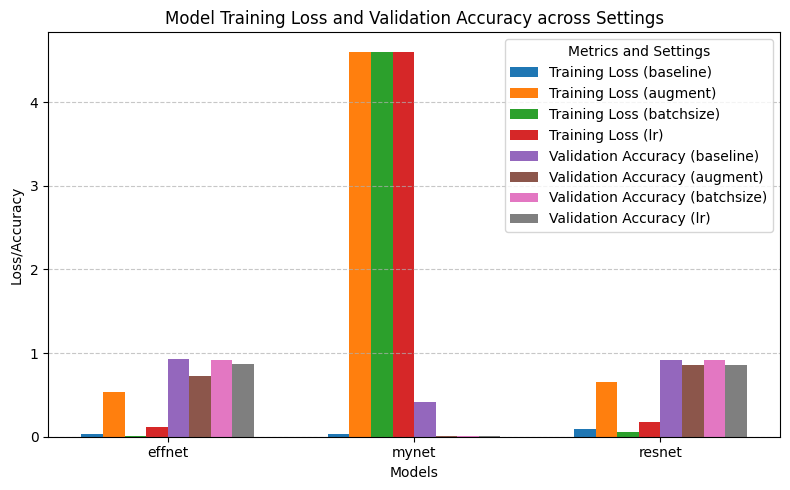

In [ ]:
folders = ["result", "result_augment", "result_batchsize", "result_lr"] 
plot_metrics_bar_chart(folders)

In [46]:
def plot_metrics_line_graph(model_name, folders):
    '''
    Plot training loss and validation accuracy over epochs for a specific model across multiple settings 
    on a single plot with two Y-axes.
    
    Args:
    - model_name (str): The model name to plot (e.g., 'effnet').
    - folders (list of str): List of folder paths containing metric CSV files.
    '''
    from matplotlib.ticker import MaxNLocator
    data = []  # To store data from all folders

    # Load data from each folder
    for folder in folders:
        loss_file = None
        acc_file = None
        for file in os.listdir(folder):
            filepath = os.path.join(folder, file)
            if f"losses_train_{model_name}" in file:
                loss_file = filepath
            elif f"accus_valid_{model_name}" in file:
                acc_file = filepath
        
        if loss_file and acc_file:
            losses = pd.read_csv(loss_file).values.flatten().tolist()  # Get loss values
            accus = pd.read_csv(acc_file).values.flatten().tolist()   # Get accuracy values
            data.append((folder, losses, accus))  # Store folder name, losses, and accuracies

    # Plot
    fig, ax1 = plt.subplots(figsize=(8, 5))
    ax2 = ax1.twinx()
    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']  # Define colors for each setting
    
    for i, (folder, losses, accus) in enumerate(data):
        epochs = range(1, len(losses) + 1)
        color_loss = colors[i % len(colors)]  # Color for loss
        color_acc = colors[i % len(colors)]  # Same color for accuracy to match settings

        # Plot training loss
        label = folder.replace('result_', '') if 'result_' in folder else 'baseline'
        ax1.plot(epochs, losses, label=label, color=color_loss, linestyle='--')
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Training Loss")

        # Plot validation accuracy on secondary axis
        ax2.plot(epochs, accus, label=label, color=color_acc)
        ax2.set_ylabel("Validation Accuracy")

    ax2.yaxis.set_major_locator(MaxNLocator(nbins=6))  # Reduce number of ticks

    # Title, legend, and grid
    fig.suptitle(f"Loss and Accuracy Over Epochs for {model_name} Across Settings")
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.grid(linestyle="--", alpha=0.7)
    fig.tight_layout()
    plt.show()

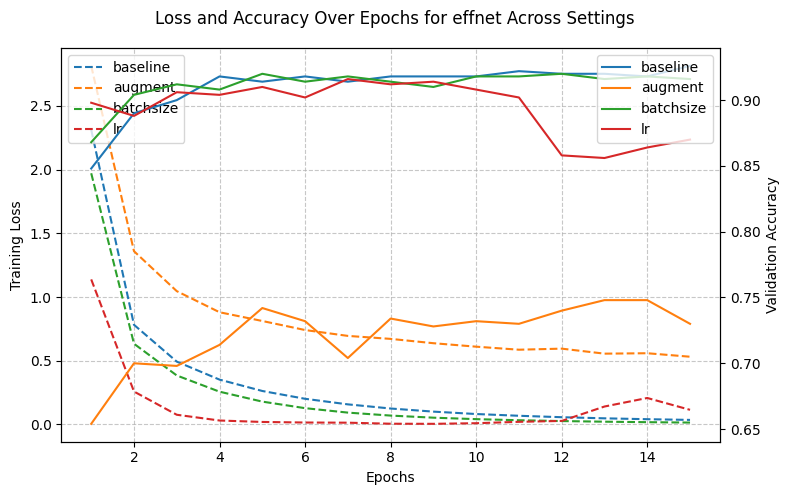

In [ ]:
plot_metrics_line_graph("effnet", folders)

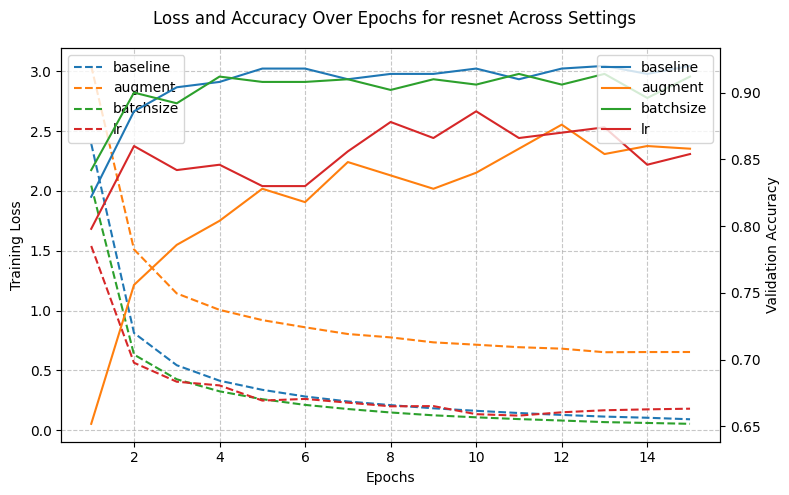

In [ ]:
plot_metrics_line_graph("resnet", folders)

In [50]:
plot_metrics_line_graph("mynet", folders)

NameError: name 'plot_metrics_line_graph' is not defined